# Introduction to text analytics

This notebook contains a tutorial introduction to basic text analytics with Python.  Raw text data is an unstructured and ubiquitous type of data. Most of the world’s data is unstructured. Volumes of unstructured data, including text, are growing much faster than structured data. There are many industry estimates for the fraction of all data which is unstructured. How much text data are we talking about here? In a few years time, Twitter has [more text data recorded](http://www.internetlivestats.com/twitter-statistics/) than all that has been written in print in the history of mankind.

Given the ubiquity and volume of text data, it is not surprising that numerous powerful applications which exploit text analytics are appearing. A few of these applications are listed below.

- Intelligent applications
  - Assistants
  - Chat bots
- Classification
  - Sentiment analysis
  - SPAM detection
- Speech recognition
- Search
- Information retrieval
- Legal discovery

In this tutorial we investigate three areas of text analytics. The following three sections cover these topics.

- Preparing text for analysis
- Classification of text and sentiment analysis
- Topic Models for document classification and retrieval.

In [1]:
# !pip install editdistance
# !pip install nltk
# !pip install gensim

In [2]:
import csv
import editdistance
import string
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cProfile
import argparse
import pprint
import seaborn as sns

from nltk.corpus import stopwords
from scipy.sparse import coo_matrix
from collections import Counter
import gensim

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

ModuleNotFoundError: No module named 'editdistance'

In [3]:
nltk.download('wordnet')
nltk.download('stopwords')

# If you get an SSL-certificate error, and you are on a MAC then you may have to navigate to: application/python3/ and
# run/double-click on the command 'install certificates'.  Then try this again.

from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sethmott\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sethmott\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


By its very nature, text data comes unstructured and poorly organized for analysis. Typically multiple steps are required to process text into a form suitable for analysis. You can think of this process as transforming the unstructured data into a structured set of features.

There are many more approaches for text analytics and natural language processing (NLP). We only mention a few below. Note that the collection of unique words in the data is called a **corpus**. To avoid having a corpus that's too large, we can trim the corpus by keeping the most frequent $N$ words, making $N$ the size of the corpus. A **document** usually refers to a single data point with raw text, such as a tweet, a review, an invoice, etc.

- The **bag of words model** is a simple widely used and surprisingly effective model for analysis of text data. The BOW model creates a **sparse vector representation** of each word in the corpus based on the frequency of the words in the document. The order of the words is not considered, nor is the similarity between different words. Despite serious shortcomings, the model can work well in many cases. 
- We can usually do much better by using **word embeddings**, which are **dense vector respresentations** for each word in the corpus. Word embeddings are learned by examining the word's **context** (other words around it). Word embeddings are very common in deep learning applications of NLP, although the embeddings themselves are learned using a shallow network.
- Another widely used model is of **part-of-speech (PoS) tagging**. PoS tagging attempts to label or annotate words in a corpus as nouns, verbs, pronouns, etc, and creates a tree of relationships between the words in the document. PoS tagging is beyond the scope of this tutorial.

## Quantifying text

Whether we have numeric or text data, there are many distance metrics we can use, and the choice of the metric we use can affect the results we get when using algorithms that rely on distances between data points, such as k-means clustering, SVMs, etc. Note that by "data points" we are referring to two features represented as **vectors**. The most common distance metric is the **Euclidean distance**, but there are many other choices such as **Manhattan distance** or **cosine similarity** (similarity is the inverse of distance). There are also distance metrics we can use specifically for words, if we represent each word as a vector whose $i$th position is filled by the word's $i$th letter. Here are some examples:

- The **Hamming distance** lines up strings and counts the number of positions that are the different. The strings must have the same length. For example, the Hamming distance between "bear" and "beer" is 1.
- The **Levenshtein distance** (also called the **edit distance**), measure the distance between two strings of variable length by counting the number of insertions, deletions, substitutions needed to convert one string into the other. For example, the Levenshtein distance between "banana" and "ban" is 3, because 3 insertions are needed. In Levenshtein distance specifically, substitutions have a cost of 2, while insertions and deletions have a cost of 1 associated with each.
- The **Jaccard index** measures the size of intersection of characters divided by size of union of characters.

  $$J(A, B) = 1 - \frac{|A \cap B|}{|A \cup B|}$$

  For example, $J(\text{beer}, \text{bear}) = 1 - \frac{3}{4}$. Note that if we do not subtract the ratio from one, we get the Jaccard **similarity**. So the distance is one minus the similarity (and vice versa).
- The **weighted Jaccard index** is based on the minimum number of times $m_i$ that a letter appears and the maximum number of times $M_i$ it appears in both words **combined**. We then measure their distance as such:

  $$J'(A, B) = 1 - \frac{\sum m_i}{\sum M_i}$$

  For example, $J'(\text{beer}, \text{bear}) = 1 - \frac{m_a + m_e + m_b + m_r}{M_a + M_e + M_b + M_r} = 1 - \frac{0 + 1 + 1 + 1}{1 + 2 + 1 + 1} = 1 - \frac{3}{5}$.

We can try to implement these distances with Python, but this would be more akin to a programming exercise, so instead we call functions from third-party libraries when needed.

## Text cleaning and preprocessing

The very first step to prepare text is to clean it.  We clean and normalize the text by performing various operations on the text. Some examples are as follows:

- Make the text lowercase.
- Remove symbols or punctuation.
- Remove numbers. May also replace all numbers with a numeric tag, for example `<NUM>` or similar. We may also consider replacing all dates with `<DATE>` or similarly use tags `<URL>`, `<PHONE>`, `<EMAIL>`, etc...
- Strip extra white space. White space has many forms: space, newline, or tab. There are also other rarely used unicode specifications for other white space characters.
- Remove all non-printable unicode characters.
- Replace accent characters.
- Remove 'stop words'. Stop words are generally non-informative words like "the", "as", "a", etc.
- Stem words to similar endings, such as "eats" and "eat".

There are a few reasons to clean your text.  The primary reason is to reduce the potential vocabulary and increase the observations of specific words (or tokens). Depending on the application, the above steps should be considered carefully and only applied when it makes sense. Ask yourself if words like "China" and "china" to be different.

**NOTE**: Be careful dealing with unicode characters. There are many editors and text viewers that only display printable characters but will not remove non-printable characters. Strange unicode characters can end up in data from users blindly copy/pasting text (with invisible unicode) into other text boxes.

### Exercise

Here's a horrible tweet. We're going to clean it and learn about ways to clean text data in the process.

In [4]:
horrible_tweet_text = 'I <3 statistics $\ \ $, it’s my \u1072  $\ \ $    fAvoRitE!! 11!!!'
print('Unfiltered text: \n{}\n'.format(horrible_tweet_text))

Unfiltered text: 
I <3 statistics $\ \ $, it’s my ၲ  $\ \ $    fAvoRitE!! 11!!!



Step by step, refine the above text. To avoid overwriting the existing string, you can create a new string from the string so far each time.

- Remove any non-ASCI character. A string `x` is ASCI if `ord(x) < 128`.

- Make all the letters lower case.

- Remove all punctuation from the text. You can use `string.punctuation` to get a string of all punctuation characters.

- Remove all the numbers from the text. HINT: If you are familiar with **regular expressions** you can use `re.sub` to do this easily.

- Strip the text of any extra whitespace. HINT: The `split` method might help here.

- Remove all stop words from the text. We can use `stopwords.words('english')` to get a list of stop words for the English language.

- Let's now use `WordNetLemmatizer()` to reduce the words to their **stems**. HINT: Use the object's `lemmatize` method.

In [32]:
lmtzr = WordNetLemmatizer()

### End of exercise

Let's now combine the steps outlined in the above exercise and create a function to clean text for use. We will later use this function.

In [5]:
def preprocess(text, list_of_steps):
    
    for step in list_of_steps:
        if step == 'remove_non_ascii':
            text = ''.join([x for x in text if ord(x) < 128])
        elif step == 'lowercase':
            text = text.lower()
        elif step == 'remove_punctuation':
            punct_exclude = set(string.punctuation)
            text = ''.join(char for char in text if char not in punct_exclude)
        elif step == 'remove_numbers':
            text = re.sub("\d+", "", text)
        elif step == 'strip_whitespace':
            text = ' '.join(text.split())
        elif step == 'remove_stopwords':
            stops = stopwords.words('english')
            word_list = text.split(' ')
            text_words = [word for word in word_list if word not in stops]
            text = ' '.join(text_words)
        elif step == 'stem_words':
            lmtzr = WordNetLemmatizer()
            word_list = text.split(' ')
            stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
            text = ' '.join(stemmed_words)
    return text

step_list = ['remove_non_ascii', 'lowercase', 'remove_punctuation', 'remove_numbers',
            'strip_whitespace', 'remove_stopwords', 'stem_words']

print("before: \"{}\"".format(horrible_tweet_text))
print("after : \"{}\"".format(preprocess(horrible_tweet_text, step_list)))

before: "I <3 statistics $\ \ $, it’s my ၲ  $\ \ $    fAvoRitE!! 11!!!"
after : "statistic favorite"


## Text preparation
Unstructured text must be processed into a uniform set of features suitable for further analysis. In this section we will step through some of the commonly used methods for converting unstructured text into a form we can use for analysis. 

### Tokenize text

As a first step in preparing text for analysis of a document is to **tokenize** the text. In general terms, tokenization is the process dividing raw text into words, symbols and other elements, known as **tokens**. A set of tokens from all documents in the data is known as a **corpus**.

As a first step in creating a corpus is reading the data set. This particular data set is comprised of 160,000 tweets. The sentiment of these tweets has been human labeled as positive or negative (4 is for positive).

In [6]:
data_file = 'https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/twitter_data.csv'
tweet_df = pd.read_csv(data_file)
tweet_df.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [7]:
tweet_df['sentiment_label'] = tweet_df['sentiment_label'].replace(4, 1)
tweet_df['sentiment_label'].value_counts()

1    80000
0    80000
Name: sentiment_label, dtype: int64

In [8]:
tweet_data = tweet_df.values.tolist()

Now that we have the data set read, we need to clean then tokenize the tweets. Note that stemming can be slow on large datasets.

In [9]:
steps = ['lowercase', 'remove_punctuation', 'remove_numbers', 'strip_whitespace', 'stem_words']
tweet_df['clean_tweet'] = tweet_df['tweet_text'].map(lambda s: preprocess(s, steps))

In [10]:
tweet_df.head()

,sentiment_label,tweet_text,clean_tweet
0,1,"@elephantbird Hey dear, Happy Friday to You A...",elephantbird hey dear happy friday to you alre...
1,1,Ughhh layin downnnn Waiting for zeina to co...,ughhh layin downnnn waiting for zeina to cook ...
2,0,"@greeniebach I reckon he'll play, even if he's...",greeniebach i reckon hell play even if he not ...
3,0,@vaLewee I know! Saw it on the news!,valewee i know saw it on the news
4,0,very sad that http://www.fabchannel.com/ has c...,very sad that httpwwwfabchannelcom ha closed d...


It's sometimes helpful to profile such functions to find the main culprits and see if we can do anything to speed them up.

In [11]:
import cProfile
cProfile.run("tweet_df['tweet_text'].map(lambda s: preprocess(s, steps))")

         46070046 function calls (46070043 primitive calls) in 55.299 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
        4    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:997(_handle_fromlist)
   160000    2.868    0.000   54.424    0.000 <ipython-input-5-0f7b3a1f02b1>:1(preprocess)
 11257197    4.353    0.000    4.353    0.000 <ipython-input-5-0f7b3a1f02b1>:10(<genexpr>)
   160000    1.986    0.000   40.170    0.000 <ipython-input-5-0f7b3a1f02b1>:23(<listcomp>)
   160000    0.599    0.000   55.023    0.000 <string>:1(<lambda>)
        1    0.010    0.010   55.299   55.299 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 _dtype.py:319(_name_includes_bit_suffix)
        2    0.000    0.000    0.000    0.000 _dtype.py:333(_name_get)
        2    0.000    0.000    0.000    0.000 _dtype.py:36(_kind_nam

### Term document matrix

Now that we have a corpus with some basic normalization applied, we can create a **term document matrix (TDM)**. The TDM is a representation for a **bag of words** model. The TDM is a sparse matrix, as most documents do not include many of the terms. Sparse matrix coding must be used for efficiency. The rows represent the terms and the columns are the documents, so the entries show the frequency of each term for each document.

![](https://library.startlearninglabs.uw.edu/DATASCI410/img/tdm.png)

Let's compute this for an example text:

In [56]:
example_texts = [
    'machine learning is so much fun',
    'i think learning is fun',
    'machines can learn',
    'i think coding is fun'
]

vocab = set() # create the vocabulary
for text in example_texts:
    words = text.split(' ')
    vocab.update(set(words))

vocab_list = list(vocab)
print('Vocabulary Size: {} distinct words.\n'.format(len(vocab_list)))

# create term-document matrix
d_t_matrix = np.zeros((len(vocab), len(example_texts)), dtype = np.intc)
for doc_ix_col, text in enumerate(example_texts):
    text_words = text.split(' ')
    row_ixs = [vocab_list.index(word) for word in text_words if word in vocab_list]
    d_t_matrix[row_ixs, doc_ix_col] = 1

print(vocab_list)
print(d_t_matrix)

Vocabulary Size: 12 distinct words.

['i', 'fun', 'machine', 'machines', 'think', 'much', 'learn', 'coding', 'learning', 'can', 'so', 'is']
[[0 1 0 1]
 [1 1 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [0 1 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [1 1 0 1]]


You can imagine that with a large corpus, our term-document matrix will get very sparse very quickly. As a sparse matrix, we store the occurrences with coordinates and values. This type of sparse matrix is called a **COO matrix** or a coordinate matrix.

Let's see how to do this for the tweet-data.

In [57]:
clean_texts = tweet_df['clean_tweet']
docs = {}
labels = []
for ix, row in enumerate(clean_texts):
    labels = tweet_data[ix][0]
    docs[ix] = row.split(' ')

print('Example entry: {}'.format(docs[np.random.choice(ix)]))

Example entry: ['pyoorgrant', 'i', 'totally', 'will', 'really', 'i', 'neeeed', 'money']


We want to keep track of how many unique words there are.

In [58]:
num_nonzero = 0
vocab = set()

for word_list in docs.values():
    unique_terms = set(word_list)    # all unique terms of this tweet
    vocab.update(unique_terms)       # set union: add unique terms of this tweet
    num_nonzero += len(unique_terms) # add count of unique terms in this tweet

doc_key_list = list(docs.keys())

print('Our tweet-vocabulary has {} distinct words.'.format(len(vocab)))

Our tweet-vocabulary has 146496 distinct words.


Let's now convert everything to a numpy array. We should keep track of how the vocab/term indices map to the matrix so that we can look them up later.

In [60]:
doc_key_list = np.array(doc_key_list)
vocab = np.array(list(vocab))

vocab_sorter = np.argsort(vocab)

print('Vocab: {}'.format(vocab[:5]))
print('Sorted Vocab: {}'.format(vocab[vocab_sorter[:5]]))

Vocab: ['mccurdy' 'area' 'skipd' 'watt' 'levelchick']
Sorted Vocab: ['a' 'aa' 'aaa' 'aaaa' 'aaaaa']


A COO matrix is just a tuple of data, row indices, and column indices. Everything else is assumed to be zero.

In [61]:
num_docs = len(doc_key_list)
vocab_size = len(vocab)
data = np.empty(num_nonzero, dtype = np.intc)     # all non-zero
rows = np.empty(num_nonzero, dtype = np.intc)     # row index
cols = np.empty(num_nonzero, dtype = np.intc)     # column index

It's time to compute the full term-document sparse matrix.

In [62]:
ix = 0
# go through all documents with their terms
print('Computing, please wait!')
for doc_key, terms in docs.items():
    # find indices to insert-into such that, if the corresponding elements were
    # inserted before the indices, the order would be preserved
    term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter=vocab_sorter)]

    # count the unique terms of the document and get their vocabulary indices
    uniq_indices, counts = np.unique(term_indices, return_counts=True)
    n_vals = len(uniq_indices)  # = number of unique terms
    ix_end = ix + n_vals # Add count to index.

    data[ix:ix_end] = counts                  # save the counts (term frequencies)
    cols[ix:ix_end] = uniq_indices            # save the column index: index in 
    doc_ix = np.where(doc_key_list == doc_key)   # get the document index for the document name
    rows[ix:ix_end] = np.repeat(doc_ix, n_vals)  # save it as repeated value

    ix = ix_end  # resume with next document -> will add future data on the end.

print('Done!')

Computing, please wait!
Done!


Let's look at our sorted vocabulary again.

In [63]:
print('First five terms alphabetically: {}'.format(vocab[vocab_sorter[:5]]))

First five terms alphabetically: ['a' 'aa' 'aaa' 'aaaa' 'aaaaa']


As you can see, we probably need to do some trimming, as the word 'aaaaa' probably doesn't occur often enough, and having 151,670 unique words may be too much.  We will address this later on. For now, let's create the sparse coordinate matrix.

In [64]:
doc_term_mat = coo_matrix((data, (rows, cols)), shape = (num_docs, vocab_size), dtype = np.intc)

In [65]:
# let's check to make sure!
vocab_list = list(vocab)
word_of_interest = 'math'
vocab_interesting_ix = list(vocab).index(word_of_interest)
print('vocab index of {} : {}'.format(word_of_interest, vocab_interesting_ix))
# find which tweets contain word
doc_ix_with_word = []
for ix, row in enumerate(tweet_data): # note on this line later
    if word_of_interest in row[1]:
        doc_ix_with_word.append(ix)

print('\n1st document index containing said word: {}'.format(doc_ix_with_word[0]))
print('\nTweet: {}'.format(tweet_data[doc_ix_with_word[0]]))

# document - term matrix relevant entry
document_row = doc_ix_with_word[0]
vocab_col = vocab_interesting_ix
mat_entry = doc_term_mat.tocsr()[document_row, vocab_col]

print('\nDocument-Term Matrix entry: {}'.format(mat_entry))

vocab index of math : 106035

1st document index containing said word: 171

Tweet: [1, 'yayyy, i miss out on science and math tomoro!!  but then i have french in the morning. eugh, fair trade =__=']

Document-Term Matrix entry: 1


We have to be careful with our usage of test-words and python's `in` function.  Imagine we have a tweet that has punctuation or the word is a sub-sequence of another word, then the `in` function would tag the document as true, but our cleaning/parsing would not have that as a separate word.

You can see for yourself what is happening if you use the test word "python".

### Trimming the document-term matrix

We saw above that we are including terms like 'aaaaa' and 'aaaa', which probably occur very few times. These terms generally occur with unstructured text fields because we allow users to input whatever they feel like and that includes typos.  But be aware that they can also be artifacts of our cleaning process (unintentionally and intentionally).

Since our document-term matrix is a matrix of counts of words (columns) in each document (rows), we want to remove words that don't occur very frequently across our corpus. The count of how frequent a word is in all of our corpus is just the sum of each column.

In [66]:
word_counts = doc_term_mat.sum(axis = 0)
print(word_counts)

[[  1 134   1 ...   1   1   2]]


Let's look at how many words are above a specific cutoff:

In [67]:
cutoff = 15
word_count_list = word_counts.tolist()[0]
col_cutoff_ix = [ix for ix, count in enumerate(word_count_list) if count > cutoff]

print('Number of words w/counts above {} : {}'.format(cutoff, len(col_cutoff_ix)))

Number of words w/counts above 15 : 5856


We can now trim our vocabulary and document term matrix.

In [69]:
vocab_trimmed = np.array([vocab[x] for x in col_cutoff_ix])
vocab_sorter_trimmed = np.argsort(vocab_trimmed)

print('Shape of document-term matrix before trimming: {}'.format(doc_term_mat.shape))

doc_term_mat_trimmed = doc_term_mat.tocsc()[:,col_cutoff_ix]
print('Shape of document-term matrix after trimming: {}'.format(doc_term_mat_trimmed.shape))

Shape of document-term matrix before trimming: (160000, 146496)
Shape of document-term matrix after trimming: (160000, 5856)


In [70]:
# Look at first 10 words alphabetically
vocab_trimmed[vocab_sorter_trimmed[0:10]]

array(['a', 'aa', 'aaa', 'aaaah', 'aaah', 'aah', 'aaron', 'ab',
       'abandoned', 'abby'], dtype='<U37')

How do we know what cutoff we should use? Let's look at a bar graph of frequency of words before and after we trimmed it.

In [77]:
pd.value_counts(word_count_list, normalize = True)

1       0.749986
2       0.099764
3       0.037080
4       0.019652
5       0.012581
          ...   
837     0.000007
453     0.000007
197     0.000007
3013    0.000007
315     0.000007
Length: 853, dtype: float64

There are too many words that appear few times. Let's check out the trimmed list.

In [83]:
trimmed_word_counts = doc_term_mat_trimmed.sum(axis = 0)
trimmed_word_list = trimmed_word_counts.tolist()[0]
pd.value_counts(trimmed_word_list, normalize = True)

16      0.040813
17      0.040471
18      0.033470
19      0.030396
21      0.028176
          ...   
2459    0.000171
410     0.000171
398     0.000171
390     0.000171
1945    0.000171
Length: 838, dtype: float64

Note that 15 might be a good cutoff because we get a visible drop off and for our next model, ~6000 features may not be too much.  These types of **hyperparameters** for the model will probably need tuning.

The best way to find the cutoff is to test various model preprocessing through a train-test-validation split.  Train multiple versions and compare them on the test set.  Then report the best resulting model's performance on the validation set.

### Computing TF-IDF

Now that we have computed a document-term matrix, how can we understand it? Recall that the simple **bag of words model** is just based on **term frequency (TF)** where $\text{TF(term, doc)}$ is the frequency of some term in a given document.

We can also derive the **inverse document frequencies (IDF)**:

$$\text{IDF(term)} = \log(\frac{\text{number of documents}}{\text{number of documents with term in it} + 1})$$

Here's what the IDF function looks like:

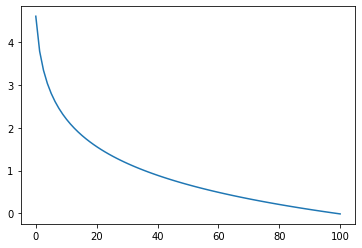

In [22]:
x = np.linspace(0, 100, num = 80)
sns.lineplot(x = x, y = np.log(100 / (x + 1)));

TFs give us a measure of the relevancy of a term to a document, but of course TFs for common terms will be inflated. So we can use IDFs to "normalize" the TFs and dampen the relevancy of terms that appear frequently across documents by virtue of being common terms. In other words, IDFs can serve as a factor to emphasize rare terms. This results in **term frequency inverse document frequency (TF-IDF) maxtrix**. 

$$\text{TF-IDF} = \text{TF(term, doc)} \cdot \text{IDF(term)}$$

Applications of TF-IDF include

- Characterize writing styles
- Comparing authors
- Determining original authors
- Finding plagiarism

The code in the cell below computes both simple TF and the cumulative of the term frequencies, starting from the most frequent terms to the least. We can use a built-in TF-IDF transformation function to do the calculations.

In [84]:
vectorizer = TfidfVectorizer(sublinear_tf = True, max_df = 0.5, max_features = 6228, stop_words = 'english')
clean_texts = tweet_df['clean_tweet']
tf_idf_tweets = vectorizer.fit_transform(clean_texts)

tf_idf_tweets

The 'csr' (compressed sparse row) format is used by `sklearn` to store the matrix.

## Classification and sentiment analysis

Now that we have a prepared TDM of the 160,000 tweets, let's build and evaluate models to classify the sentiment of these tweets. An outline of our process is as follows:

- Use TDM or TF-IDF weighted TDM as features for training the model.
- Use marked cases for training and evaluation of model.
- Select a method for sparse matrix requires regularization from the following:
  - Feature selection, is impractical since there are over one million features.
  - SVD/PCA could be used to reduce dimensionality of the problem.
  - In this case we will use the ridge and lasso methods offered in the  elasticnet model.

Let's split the tf-idf sparse matrix. For training we will use 120,000 tweets to predict the 0,1 sentiment. The remaining 40,000 cases will be used to evaluate the model.

In [88]:
y_targets = np.array([y[0] for y in tweet_data])
X_train, X_test, y_train, y_test = train_test_split(tf_idf_tweets, y_targets, test_size = 40000, random_state = 42)

Now let's train a logistic classifier on the data:

In [92]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's now evaluate the model.

In [93]:
train_probs = lr.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = lr.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

In [94]:
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

Train accuracy: 0.7793333333333333
Test accuracy: 0.75625


Let's also compute the precision, recall and Fscore of the model for positive and negative tweets.

Recall that a positive prediction here means a positive review, and so **precision** is the proportion of correct predictions among all positive predictions and **recall** is the proportion of correct predictions among all true positives. **F1** is the harmonic average of precision and recall.

In [95]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_results)
tn, fp, fn, tp = confusion_matrix(y_test, test_results).ravel()

print(confusion_matrix(y_test, test_results))
print('='*35)
print('             Class 1   -   Class 0')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

[[14624  5432]
 [ 4318 15626]]
             Class 1   -   Class 0
Precision: [0.77204097 0.74204578]
Recall   : [0.72915836 0.78349378]
F1       : [0.74998718 0.76220672]
Support  : [20056 19944]


## OPTIONAL: Topic models

It is often useful to allocate documents to one or more topics. This process can be useful in, say, information retrieval and search. Models to perform this allocation to topics are known as **topic models**. 

A powerful topic model is know as **latent Dirichlet allocation** or **LDA**. LDA is an unsupervised Bayesian learning model.  We can summarize the LDA model as follows:

- The LDA model uses a fixed number of topics, $k$.
- The model computes the posterior probability of a document containing a topic.
- All other variables are estimated or **latent**, including the topics of each document.

How does latent Dirichlet allocation work? It's a Bayesian model, so we need to define a likelihood and choose a prior. What we actually know are the term frequencies. What we want to know (the latent variable) is the topic distribution (allocation) for a given document. Based on the distribution, we can categorize the document.

Since we don't know the allocation of topics in advance we generally use uniform priors across topics. The likelihood is taken from the term-document matrix. We leave it to the reader to learn more about the math behind it. Instead, let's try an example. In this example we apply LDA to a corpus of 20 business news articles from Reuters news wire concerning the oil industry. We will apply an LDA model with 5 topics ($k = 5$).

As a first step we will load the corpus of these documents. Execute the code in the cell below to load the corpus and examine the contents of the first document.

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 3000
n_features = 500
n_components = 10
n_top_words = 5

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #{}: ".format(topic_idx)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


print("Loading data set. Please wait.")
news_data = fetch_20newsgroups(shuffle=True, remove=('headers', 'footers', 'quotes'))
small_data = news_data.data[:n_samples]
print('Done!')

Loading data set. Please wait.
Done!


We now get the term document matrix.

In [98]:
count_vectorizer = CountVectorizer(max_df = 0.9, min_df = 5, max_features = n_features, stop_words = 'english')
tf = count_vectorizer.fit_transform(small_data)

Now we train an LDA model.

In [100]:
lda = LatentDirichletAllocation(n_components, max_iter=5, learning_method='online', learning_offset=50.)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

Here are the top words for each topic that was found.

In [101]:
tf_feature_names = count_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: edu key com mail new
Topic #1: god jesus believe does bible
Topic #2: 17 year 11 12 10
Topic #3: windows dos game team games
Topic #4: don just people think like
Topic #5: file program use files available
Topic #6: people government jews turkish armenian
Topic #7: drive card scsi disk pc
Topic #8: space 00 50 nasa new
Topic #9: ax max b8f 145 pl



##  Summary

NLP applications extend far and wide, so we only stratched the surface here. Many of the modern breakthroughs in deep learning for example have been in NLP. One reason for this is that language data is abundant and the lack of structure in the data presents us with many challenges and learning opportunities. We hope this notebook exposed you to just some examples.